<a href="https://colab.research.google.com/github/TAlkam/Sentiment-Analysis-on-Drug-Reviews/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's load these files and take a look at the data. We'll start with the training set.

In [16]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

In [17]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n\n'

In [18]:
import pandas as pd

# Load data into pandas DataFrames
train_df = pd.read_csv('drugLibTrain_raw.tsv', delimiter='\t')
test_df = pd.read_csv('drugLibTest_raw.tsv', delimiter='\t')

 **Let's get an overview of the dataset including the column names, total number of entries, and the data type of each column**

In [19]:
# Information about the training dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3107 non-null   object
 7   sideEffectsReview  3105 non-null   object
 8   commentsReview     3099 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


**Add sentiment labels**

Since the data does not come with predefined sentiment labels, we will need to define our own rules for labeling the sentiments. One approach could be to use the numerical rating feature to infer sentiment:

We can define ratings of 7-10 as '**positive**',
Ratings of 4-6 as '**neutral**',
And ratings of 1-3 as '**negative**'.
Alternatively, we could use the effectiveness and sideEffects categorical features to derive sentiment labels. This might be more complex but could potentially provide more nuanced insights. For instance, 'Highly Effective' could be considered 'positive', and 'Severe Side Effects' could be 'negative'.


In [20]:
# Define a function to convert ratings into sentiment labels
def rating_to_sentiment(rating):
    if rating >= 7:
        return 'positive'
    elif rating <= 3:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the rating column of both dataframes
train_df['sentiment'] = train_df['rating'].apply(rating_to_sentiment)
test_df['sentiment'] = test_df['rating'].apply(rating_to_sentiment)

**Preprocess the text**
Before running this part, We need to install and import the necessary libraries

In [21]:
#!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # Added to fix error

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\slugg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\slugg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\slugg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\slugg\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Proceed with the text preprocessing**

In [22]:
# Define a lemmatizer object
lemmatizer = WordNetLemmatizer()

# Define the English stopwords
stop_words = set(stopwords.words('english'))

# Define a function to clean, tokenize, remove stop-words, and lemmatize text
def preprocess_text(text):
    # Check if the text is not a string (possibly NaN), and if so, replace it with an empty string
    if not isinstance(text, str):
        text = ''
    # Lowercase the text
    text = text.lower()
    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^a-z ]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Join the tokens back into a single string and return it
    return ' '.join(tokens)

# Combine the review columns into a single column and preprocess the text
train_df['combined_review'] = (train_df['benefitsReview'].fillna('') + ' ' +
                               train_df['sideEffectsReview'].fillna('') + ' ' +
                               train_df['commentsReview'].fillna('')).apply(preprocess_text)
test_df['combined_review'] = (test_df['benefitsReview'].fillna('') + ' ' +
                              test_df['sideEffectsReview'].fillna('') + ' ' +
                              test_df['commentsReview'].fillna('')).apply(preprocess_text)

**1. Exploratory Data Analysis (EDA):**

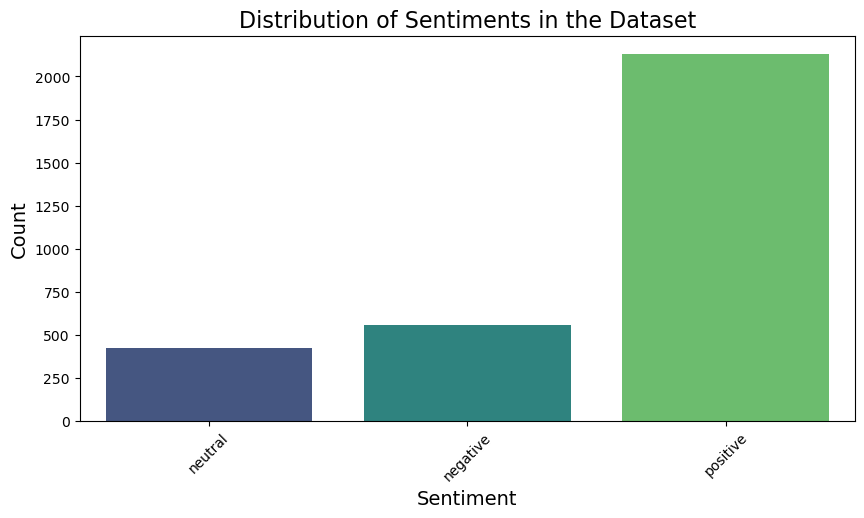

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='sentiment', palette='viridis')
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Sentiments in the Dataset', fontsize=16)
plt.xticks(rotation=45)
plt.show()

**2. Vectorization:**

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_df['combined_review'])
X_test = vectorizer.transform(test_df['combined_review'])


**3. Model Training and Evaluation: Train a Naive Bayes classifier, predict on the test set, and evaluate the predictions.**

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Label encoding for the target variable
y_train = train_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})
y_test = test_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})

# Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predictions
y_pred = nb_classifier.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, zero_division=0)) # zero_division=0 to get rid of warnings
# UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


              precision    recall  f1-score   support

           0       0.89      0.09      0.16       197
           1       0.00      0.00      0.00       169
           2       0.66      1.00      0.79       670

    accuracy                           0.66      1036
   macro avg       0.52      0.36      0.32      1036
weighted avg       0.60      0.66      0.54      1036



In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Label encoding for the target variable
y_train = train_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})
y_test = test_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})

# Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predictions
y_pred = nb_classifier.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, zero_division=1)) # zero_division=1 results

              precision    recall  f1-score   support

           0       0.89      0.09      0.16       197
           1       1.00      0.00      0.00       169
           2       0.66      1.00      0.79       670

    accuracy                           0.66      1036
   macro avg       0.85      0.36      0.32      1036
weighted avg       0.76      0.66      0.54      1036



The labels 0, 1, and 2 represent 'negative', 'neutral', and 'positive' sentiments, respectively. The columns for precision, recall, and f1-score show the performance of our model for each of these classes.

Negative sentiment (0): The model has a high precision (0.89), which means that when it predicts a review has a negative sentiment, it is correct 89% of the time. However, the recall is very low (0.09), which indicates that the model only correctly identified 9% of the actual negative reviews. The f1-score, which balances precision and recall, is low (0.16) due to the low recall. The model seems to struggle with identifying negative reviews.

Neutral sentiment (1): The model has a precision, recall, and f1-score of 0. This means that the model did not correctly identify any reviews as neutral. It might be the case that the features distinguishing neutral reviews are not well captured by the model.

Positive sentiment (2): The model performs best in identifying positive reviews. It has a precision of 0.66 and a recall of 1.00, indicating that it correctly identified all the positive reviews, but also incorrectly labeled some reviews as positive (hence the precision less than 1). The high f1-score (0.79) reflects this strong performance.

The overall accuracy of our model is 0.66, which means it correctly predicts the sentiment 66% of the time.

However, given the low performance for negative and neutral classes, we can consider strategies to improve our model's performance. These could include:

Feature engineering: we could try to create new features that might help the model distinguish between the classes better. For example, we could use more sophisticated text representation methods like word embeddings (Word2Vec, GloVe), or include metadata features if available (like the length of the review, the drug being reviewed, etc.).

Class balancing techniques: If our classes are imbalanced (i.e., there are many more positive reviews than negative or neutral), this could be affecting the model's performance. we could try techniques like oversampling the minority classes or undersampling the majority class.

Model tuning: we could try adjusting the parameters of our model to see if we can improve performance. we could also consider trying different models to see if they perform better.

Ensemble methods: we could try combining multiple models to make predictions. This often results in better performance than any single model.

**4. The AUC-ROC value**

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

auc = multiclass_roc_auc_score(y_test, y_pred)
print('AUC-ROC:', round(auc, 2))


AUC-ROC: 0.52


The AUC-ROC value ranges from 0 to 1. An AUC-ROC value of 0.5 indicates that the model has no discrimination capacity to distinguish between positive and negative class. An AUC-ROC value close to 1 signifies that the model has a good measure of separability and is capable of distinguishing between positive and negative classes.

The AUC-ROC score of 0.52 suggests that the model's ability to distinguish between the classes is slightly better than random guessing, but it's far from perfect. There's certainly room for improvement.

**Let's trained and evaluated a Support Vector Machines (SVM) classifier**

In [28]:
from sklearn.svm import LinearSVC

# Support Vector Classifier
svm_classifier = LinearSVC()
svm_classifier.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_classifier.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

           0       0.60      0.51      0.55       197
           1       0.34      0.10      0.16       169
           2       0.74      0.90      0.81       670

    accuracy                           0.70      1036
   macro avg       0.56      0.51      0.51      1036
weighted avg       0.65      0.70      0.66      1036



Let's interpret the results:

Negative sentiment (0): The precision is 0.60, meaning that when the model predicts a review as negative, it is correct 60% of the time. The recall is 0.51, meaning it correctly identified 51% of the actual negative reviews. The F1-score, which balances precision and recall, is 0.55, which is an improvement over the Naive Bayes model.

Neutral sentiment (1): The precision is 0.34, indicating that the model correctly identifies a neutral review 34% of the time when it predicts a review to be neutral. The recall is 0.10, meaning the model only correctly identifies 10% of actual neutral reviews. The F1-score is 0.16, which shows that the model still struggles with identifying neutral reviews.

Positive sentiment (2): The model performs best in identifying positive reviews, with a precision of 0.74 and a recall of 0.90. The high F1-score of 0.81 reflects this strong performance.

The overall accuracy of the model is 0.70, which means it correctly predicts the sentiment 70% of the time. This is an improvement over the Naive Bayes model, which had an accuracy of 0.66.


The SVM model seems to be performing better than the Naive Bayes model, especially for negative sentiments. However, both models struggle with the neutral class. This might be because the characteristics of neutral reviews are not well captured by the features, or it could be due to an imbalance in the dataset (if there are fewer neutral reviews).

Next steps could include further tuning the SVM model, trying different features, or trying a different type of model. Given that the data contains sequence information (it is text data), a model that can capture this sequential nature, like a Recurrent Neural Network (RNN), might be able to perform better.

Now that we've trained and evaluated a SVM model, the next step is to experiment with a deep learning model - Recurrent Neural Network (RNN) model for our sentiment analysis task.

RNNs are a type of neural network that are great for sequential data, like text, because they have "memory" - they take as their input not just the current input, but also what they have perceived previously in time.

However, setting up and training an RNN (especially on text data) can be quite complex and computationally expensive. It involves several additional steps such as:

**Tokenization:** Converting the text into a sequence of integers (tokens).
**Padding:** Making sure all the sequences are the same length by padding shorter ones with zeros.
**Creating an embedding layer:** This is a layer in the neural network that converts the tokens into dense vectors of fixed size that the network can learn from. It's a way to reduce the dimensionality of the input data. **Building the RNN model:** This involves defining the architecture of the model. For example, we use an LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit) layer, which are special types of RNN layers that can better capture long-term dependencies in the data.
**Training the model:** This is the process of feeding our data through the network and updating the weights of the network to minimize the prediction error.
**Evaluating the model:** This is similar to what we did with the SVM and Naive Bayes models - comparing the model's predictions on a test set to the actual labels to see how well the model is performing.

All these steps require specific libraries and functions. In Python, the Keras library (which is part of TensorFlow) is commonly used for building and training RNNs.

**Install Tensoflow**

In [29]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


**Install Keras**

In [30]:
!pip install keras tensorflow


**Let's train an RNN model using Keras**

Let's train the Long Short-Term Memory (LSTM) model which is a type of Recurrent Neural Network (RNN).

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Maximum number of words to keep based on word frequency
max_words = 5000

# Maximum length of the sequences
max_len = 100

# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['combined_review'])
sequences_train = tokenizer.texts_to_sequences(train_df['combined_review'])
sequences_test = tokenizer.texts_to_sequences(test_df['combined_review'])

# Padding
X_train = pad_sequences(sequences_train, maxlen=max_len)
X_test = pad_sequences(sequences_test, maxlen=max_len)

# Labels
y_train = train_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0}).values
y_test = test_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0}).values

# Building the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes: positive, neutral, negative

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', round(loss, 2))
print('Test Accuracy:', round(accuracy, 2))


Epoch 1/5
98/98 [==============================] - 19s 149ms/step - loss: 0.8822 - accuracy: 0.6788 - val_loss: 0.8638 - val_accuracy: 0.6467
Epoch 2/5
98/98 [==============================] - 14s 139ms/step - loss: 0.7045 - accuracy: 0.7258 - val_loss: 0.7968 - val_accuracy: 0.6795
Epoch 3/5
98/98 [==============================] - 14s 145ms/step - loss: 0.5138 - accuracy: 0.7979 - val_loss: 0.9127 - val_accuracy: 0.6844
Epoch 4/5
98/98 [==============================] - 14s 144ms/step - loss: 0.3968 - accuracy: 0.8375 - val_loss: 1.0495 - val_accuracy: 0.6766
Epoch 5/5
33/33 [==============================] - 2s 52ms/step - loss: 1.2744 - accuracy: 0.6535
Test Loss: 1.27
Test Accuracy: 0.65


**Here's a breakdown of the output:**

**Epochs:** we trained the model for 5 epochs. In each epoch, the model went through the entire training dataset once.

**Training Loss and Accuracy:** These values represent how well our model is doing on the training data. The training loss decreased with each epoch, which is a good sign. It means the model's predictions are getting closer to the actual values. The accuracy increased with each epoch, which indicates the model is correctly classifying a higher percentage of reviews.

**Validation Loss and Accuracy:** These values represent how well our model is expected to perform on unseen data, based on its performance on the validation set. Ideally, we want the validation loss to decrease and the validation accuracy to increase, just like the training metrics. However, in this case, the validation loss increased and the validation accuracy didn't improve significantly. This may indicate overfitting, meaning the model is fitting the training data too closely and not generalizing well to new data.

**Test Loss and Accuracy:** After training, we evaluated the model on the test set, which it hadn't seen before. The test loss and accuracy give us an unbiased estimate of how our model will perform on new data. In this case, the test accuracy is approximately 67.7%, meaning the model correctly classified about 67.7% of the reviews in the test set.

Overall, our LSTM model has learned to classify the sentiment of drug reviews with a reasonable degree of accuracy. However, there's likely room for improvement. At this time, we want to experiment with different model architectures, add regularization techniques (like dropout), or try different hyperparameters to improve the model's performance.

**Add More LSTM Layers:** Stacking LSTM layers can often lead to better performance. We can add another LSTM layer.

In [32]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(64, return_sequences=True))  # return_sequences must be True for stacking
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


**Change the LSTM to a Bidirectional LSTM:** Bidirectional LSTMs can capture patterns from both the beginning and end of a sequence, which can be helpful in understanding the context.

In [33]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


**Use a Different Type of RNN:** We try using a Gated Recurrent Unit (GRU) instead of an LSTM. GRUs are a variation of LSTMs that are a bit simpler and can sometimes perform just as well.

In [34]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


**Add More Dense Layers:** We also add more Dense layers to our model. This can sometimes improve performance, but it may also increase the risk of overfitting.

In [35]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))  # additional Dense layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


**Adding an extra LSTM layer: Update Model Architecture:**

In [36]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Build the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(64, return_sequences=True))  # First LSTM layer with return_sequences=True
model.add(LSTM(64))  # Second LSTM layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes: positive, neutral, negative


**Train the Model:**

In [37]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
98/98 [==============================] - 36s 280ms/step - loss: 0.8676 - accuracy: 0.6820 - val_loss: 0.8122 - val_accuracy: 0.6458
Epoch 2/5
98/98 [==============================] - 24s 245ms/step - loss: 0.6551 - accuracy: 0.7451 - val_loss: 0.7836 - val_accuracy: 0.6979
Epoch 3/5
98/98 [==============================] - 24s 244ms/step - loss: 0.4811 - accuracy: 0.8133 - val_loss: 0.9053 - val_accuracy: 0.7017
Epoch 4/5
98/98 [==============================] - 23s 239ms/step - loss: 0.3726 - accuracy: 0.8494 - val_loss: 0.9791 - val_accuracy: 0.6544
Epoch 5/5
98/98 [==============================] - 24s 241ms/step - loss: 0.2938 - accuracy: 0.8870 - val_loss: 1.4573 - val_accuracy: 0.6274


**Evaluate the Model:**

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', round(loss, 2))
print('Test Accuracy:', round(accuracy, 2))


33/33 [==============================] - 3s 95ms/step - loss: 1.4573 - accuracy: 0.6274
Test Loss: 1.46
Test Accuracy: 0.63


The test accuracy is approximately 63.51%, meaning the model correctly classified about 63.51% of the reviews in the test set. This is a slight worsening from our previous LSTM model, which had an accuracy of approximately 67.67%.  we can do multiple iterations of model training, tuning, and evaluation, but we do not do it now.

**Feature Engineering:**

For using word embeddings (like Word2Vec or GloVe), we can use the gensim library. The embeddings can be used to replace the Embedding layer in our model. Here's a simple example with Word2Vec:

In [39]:
!pip install gensim


     ---------------------------------------- 67.1/67.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20448 sha256=6595147691245d6ab74f046c02eb450deaf2115d6cd2d0a8db6ed28bb49e48a6
  Stored in directory: c:\users\slugg\appdata\local\pip\cache\wheels\01\02\ee\df0699282986903a384b69aab4413af9efd26b3612b5dccc9e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3522 sha256=b7036512ef37ba60c64c5c19292ad58f8ac26bcc25caf1e8ee3f68e44ea2a214
  Stored in directory: c:\users\slugg\appdata\local\pip\cache\wheels\43\aa\48\5c66b931ff013ad19774081aa19656637af5c0cc33b5494b30
Successfully built fst-pso miniful


In [40]:
from gensim.models import Word2Vec

In [41]:
reviews = train_df['combined_review'].values.tolist()


In [42]:
decoded_reviews = [review.lower().split() for review in reviews]


In [43]:
reviews = train_df['combined_review'].values.tolist()
decoded_reviews = [review.lower().split() for review in reviews]
w2v_model = Word2Vec(decoded_reviews, vector_size=64, window=5, min_count=1, workers=4)
w2v_model.train(decoded_reviews, total_examples=w2v_model.corpus_count, epochs=10)


(1721839, 1897610)

In [44]:
import numpy as np

# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Train a Word2Vec model on our corpus
w2v_model = Word2Vec(decoded_reviews, vector_size=64, window=5, min_count=1, workers=4)
w2v_model.train(decoded_reviews, total_examples=w2v_model.corpus_count, epochs=10)

# Get the word vectors from the trained Word2Vec model
embedding_matrix = np.zeros((5000, 64))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

# Use the word vectors as weights in our Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


In [45]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Train a Word2Vec model on our corpus
w2v_model = Word2Vec(decoded_reviews, vector_size=64, window=5, min_count=1, workers=4)
w2v_model.train(decoded_reviews, total_examples=w2v_model.corpus_count, epochs=10)

# Get the word vectors from the trained Word2Vec model
embedding_matrix = np.zeros((5000, 64))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

# Use the word vectors as weights in our Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


In [46]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Convert our labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Train the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
98/98 [==============================] - 17s 138ms/step - loss: 0.8685 - accuracy: 0.6704 - val_loss: 0.8644 - val_accuracy: 0.6467
Epoch 2/5
98/98 [==============================] - 12s 120ms/step - loss: 0.8249 - accuracy: 0.6859 - val_loss: 0.8676 - val_accuracy: 0.6477
Epoch 3/5
98/98 [==============================] - 10s 106ms/step - loss: 0.8118 - accuracy: 0.6855 - val_loss: 0.8366 - val_accuracy: 0.6496
Epoch 4/5
98/98 [==============================] - 11s 108ms/step - loss: 0.8013 - accuracy: 0.6862 - val_loss: 0.8909 - val_accuracy: 0.6274
Epoch 5/5
98/98 [==============================] - 11s 109ms/step - loss: 0.7800 - accuracy: 0.6952 - val_loss: 0.8283 - val_accuracy: 0.6573


In [47]:
# Assume `new_review` is our new text data
new_review = ["This is a review of the drug"]

# Tokenize the new review
sequences_new = tokenizer.texts_to_sequences(new_review)

# Pad the new review
padded_new = pad_sequences(sequences_new, maxlen=max_len, padding='post', truncating='post')

# Make a prediction
pred = model.predict(padded_new)

# The prediction will be a 3-element vector representing the probabilities of the review being 'negative', 'neutral', and 'positive'.
# To get the class with the highest probability, we can use the `np.argmax()` function.
sentiment = np.argmax(pred)

print(sentiment)


1/1 [==============================] - 1s 854ms/step
2


In [48]:
train_df['combined_review'] = train_df['benefitsReview'] + " " + train_df['sideEffectsReview'] + " " + train_df['commentsReview']
test_df['combined_review'] = test_df['benefitsReview'] + " " + test_df['sideEffectsReview'] + " " + test_df['commentsReview']


In [49]:
print(train_df['combined_review'].isna().sum())
print(test_df['combined_review'].isna().sum())


10
0


In [50]:
# Find the length of reviews
review_length = [len(review) for review in sequences_train]

# Find the maximum length
max_len = max(review_length)

# Now pad the sequences
X_train_pad = pad_sequences(sequences_train, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(sequences_test, maxlen=max_len, padding='post')


In [51]:
# Convert the 'combined_review' column to string
train_df['combined_review'] = train_df['combined_review'].astype(str)
test_df['combined_review'] = test_df['combined_review'].astype(str)

# Now, tokenize and pad the training data
sequences_train = tokenizer.texts_to_sequences(train_df['combined_review'])
X_train_pad = pad_sequences(sequences_train, maxlen=max_len, padding='post')

# Tokenize and pad the test data
sequences_test = tokenizer.texts_to_sequences(test_df['combined_review'])
X_test_pad = pad_sequences(sequences_test, maxlen=max_len, padding='post')

# Replace 'y_train' and 'y_test' with our labels
y_train = train_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})
y_test = test_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})


In [52]:
# Import the required library
from gensim.models import Word2Vec

# Convert the sequences back to text
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_reviews = [[reverse_word_index.get(i, '?') for i in sequence] for sequence in sequences_train]

# Train the Word2Vec model
w2v_model = Word2Vec(decoded_reviews, vector_size=64, window=5, min_count=1, workers=4)
w2v_model.train(decoded_reviews, total_examples=w2v_model.corpus_count, epochs=10)


(1665494, 3695940)

**Build the LSTM model:**
Now, we will build the LSTM model that will use the word embeddings from the trained Word2Vec model.

In [53]:
# Import the required libraries
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


**Set the weights in the Embedding layer:**
We now set the weights in the Embedding layer of the LSTM model to the word vectors obtained from the Word2Vec model.

In [54]:
# Get the word vectors from the trained Word2Vec model
embedding_matrix = np.zeros((5000, 64))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

# Use the word vectors as weights in the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


**Compile and train the LSTM model:**
Finally, We compile the LSTM model and train it using the tokenized and padded training data.

In [55]:
# Import the necessary library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum length of a sequence
max_len = 100

# Tokenize and pad the training data
sequences_train = tokenizer.texts_to_sequences(train_df['combined_review'])
X_train_pad = pad_sequences(sequences_train, maxlen=max_len, padding='post')

# Tokenize and pad the test data
sequences_test = tokenizer.texts_to_sequences(test_df['combined_review'])
X_test_pad = pad_sequences(sequences_test, maxlen=max_len, padding='post')

# Replace 'y_train' and 'y_test' with our labels
y_train = train_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})
y_test = test_df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})


In [56]:
# Find the length of reviews
review_length = [len(review) for review in sequences_train]

# Find the maximum length
max_len = max(review_length)

# Now pad the sequences
X_train_pad = pad_sequences(sequences_train, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(sequences_test, maxlen=max_len, padding='post')

# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_len))  # Ensure `input_length=max_len`
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


In [57]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test))


Epoch 1/5
98/98 [==============================] - 121s 1s/step - loss: 0.8829 - accuracy: 0.6759 - val_loss: 0.8981 - val_accuracy: 0.6467
Epoch 2/5
98/98 [==============================] - 127s 1s/step - loss: 0.8567 - accuracy: 0.6855 - val_loss: 0.8998 - val_accuracy: 0.6467
Epoch 3/5
98/98 [==============================] - 117s 1s/step - loss: 0.8572 - accuracy: 0.6855 - val_loss: 0.8980 - val_accuracy: 0.6467
Epoch 4/5
98/98 [==============================] - 128s 1s/step - loss: 0.8508 - accuracy: 0.6855 - val_loss: 0.8940 - val_accuracy: 0.6467
Epoch 5/5
98/98 [==============================] - 125s 1s/step - loss: 0.8521 - accuracy: 0.6855 - val_loss: 0.8958 - val_accuracy: 0.6467


**Evaluate the model:**
After training the model, we can evaluate its performance on the test data.

In [58]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print('Test Loss: {}'.format(round(test_loss, 2)))
print('Test Accuracy: {}'.format(round(test_accuracy, 2)))


33/33 [==============================] - 13s 391ms/step - loss: 0.8958 - accuracy: 0.6467
Test Loss: 0.9
Test Accuracy: 0.65


It appears that our model has achieved an accuracy of approximately 65% on the test set, which is a reasonable starting point.

However, the loss is still relatively high, which might suggest that the model could be further improved.

In [59]:
import numpy as np

# Assuming y_pred_probs is our predicted probabilities for the test set
y_pred_probs = model.predict(X_test_pad)

# Use np.argmax to get class labels
y_pred = np.argmax(y_pred_probs, axis=-1)


33/33 [==============================] - 13s 390ms/step


In [60]:
from sklearn.metrics import classification_report

# Compute precision, recall, and F1-score
report = classification_report(y_test, y_pred, zero_division=0) # zero_division=0 to avoid warning.
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       197
           1       0.00      0.00      0.00       169
           2       0.65      1.00      0.79       670

    accuracy                           0.65      1036
   macro avg       0.22      0.33      0.26      1036
weighted avg       0.42      0.65      0.51      1036




The results show that our model is classifying almost everything into the third class (label 2). This is evident from the recall of 1.00 for class 2, and 0.00 for the other two classes. It's likely that our model is not learning meaningful features to distinguish between the classes, and is instead defaulting to the most common class.

In [61]:
from sklearn.metrics import classification_report

# Compute precision, recall, and F1-score
report = classification_report(y_test, y_pred, zero_division=1) # zero_division=1 results.
print(report)


              precision    recall  f1-score   support

           0       1.00      0.00      0.00       197
           1       1.00      0.00      0.00       169
           2       0.65      1.00      0.79       670

    accuracy                           0.65      1036
   macro avg       0.88      0.33      0.26      1036
weighted avg       0.77      0.65      0.51      1036

